In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import find_peaks
from codes import *
np.random.seed(12)


# MUSIC Algorithm

The variable $\Delta$ refers to the spacing between the antennas.

The variable $M$ refers to the number of antennas.

The variable $d$ refers to the direction of arrival of the signal.

The time of arrival of the signal at each antenna is defined by:

$\tau_M(\theta_i) = (M-1)\frac{\Delta \sin{\theta_i}}{c}$

The spatial frequencies are:

$\mu_i = - \frac{2\pi f_c}{c}\Delta \sin(\theta_i) \therefore \mu_i = -\pi \sin(\theta_i)$ if $\Delta = \frac{\lambda}{2}$.


In [2]:
# Definindo os parametros a serem utilizados

c_velocity = 3e8
frequency = 2.4e9 # 2.4 GHz
wavelength = c_velocity / frequency
delta = wavelength / 2 # Espaço entre cada antena

m_antennas = 8 # Número de antenas
d_arrival = 2 # Distância de chegada
theta_i = [-30, 60] # Ângulos de chegada
t_snapshot = 100 # Número de snapshots
snr = 0 # dB

$\mathbf{A_{ula}} \in \mathbb{C}^{M \times d}$ 

$\mathbf{S} \in \mathbb{C}^{d \times t}$ 

$\mathbf{N} \in \mathbb{C}^{M \times t}$ 

$\mathbf{X} = \mathbf{A_{ula}}\mathbf{S}+\mathbf{N},\;$ $\mathbf{X} \in \mathbb{C}^{M \times t}$ 

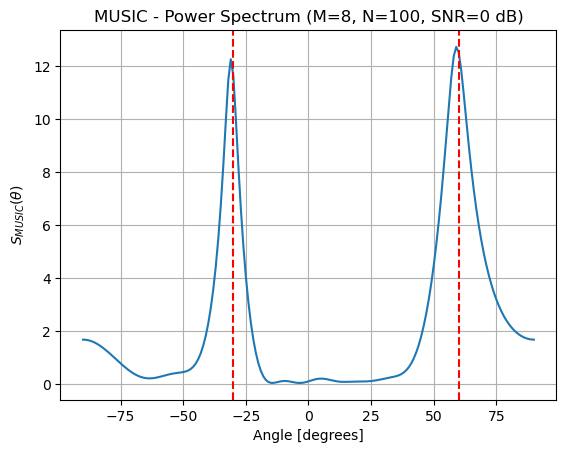

In [3]:
A_ula = gerate_a_ula(m_antennas, d_arrival, theta_i)

angles, p_spectrum = generate_music(A_ula, d_arrival, t_snapshot, m_antennas, snr)


# Plotando o espectro de potência
plt.plot(angles, lin2db(p_spectrum))
plt.xlabel('Angle [degrees]')
plt.ylabel('$S_{MUSIC}(\\theta)$')
plt.title(f'MUSIC - Power Spectrum (M={m_antennas}, N={t_snapshot}, SNR={snr} dB)')
plt.axvline(theta_i[0], color="r", linestyle="--")
plt.axvline(theta_i[1], color="r", linestyle="--")


plt.grid()
plt.savefig('music_spectrum.pdf')
plt.show()


So far, we have worked with SNR = $0$, but now we will plot for SNR = $ \{-5, 0, 5, 10, 15, 20\}$.

The change in SNR is related to the standard deviation of the noise, as the transmission power remains constant. Thus, to change the SNR, we have:

$P_{\text{noise}} = \frac{P_{t}}{\text{SNR}},$

Considering that we will transform the SNR from dB to linear and knowing that we model the noise as $P_{\text{noise}} \sim \mathcal{N}(0, \sigma^2)$, we have:

$\sigma = \sqrt{\frac{P_t}{\text{SNR}}},\; P_t = 1 \therefore \sigma = \sqrt{\text{SNR}^{-1}} = \frac{1}{\sqrt{\text{SNR}}}.$

Now, making the adjustment for the different SNR values.


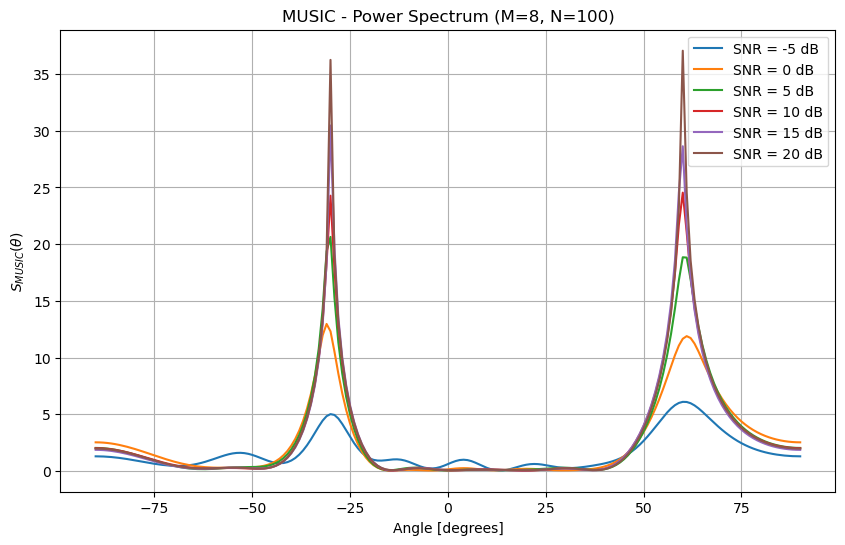

In [4]:
snr_values = np.arange(-5, 21, 5) # Valores de SNR em dB

plt.figure(figsize=(10,6))
for snr in snr_values:
    angles, p_spectrum = generate_music(A_ula, d_arrival, t_snapshot, m_antennas, snr)
    plt.plot(angles, lin2db(p_spectrum), label=f'SNR = {snr} dB')

plt.xlabel('Angle [degrees]')
plt.ylabel('$S_{MUSIC}(\\theta)$')
plt.title(f'MUSIC - Power Spectrum (M={m_antennas}, N={t_snapshot})')
plt.grid()
plt.legend()
plt.savefig('music_snrvariation.pdf')
plt.show()

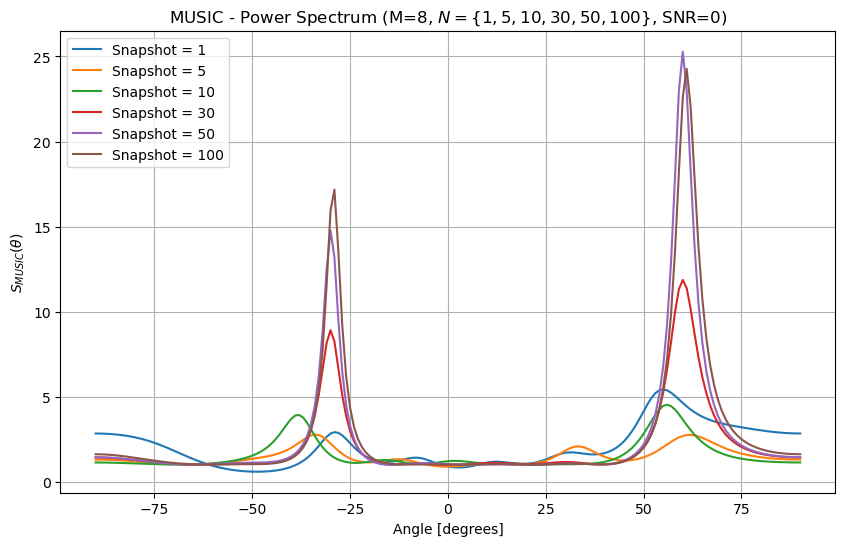

In [5]:
# Mudando agora a quantidade de snapshots:
t_snapshot_vector = [1,5,10,30,50,100]
plt.figure(figsize=(10,6))
for snapshot in t_snapshot_vector:
    angles, p_spectrum = generate_music(A_ula, d_arrival, snapshot, m_antennas, snr=0)
    plt.plot(angles, (p_spectrum), label=f'Snapshot = {snapshot}')

plt.xlabel('Angle [degrees]')
plt.ylabel('$S_{MUSIC}(\\theta)$')
plt.title('MUSIC - Power Spectrum (M=8, $N = \{1,5,10,30,50,100\}$, SNR=0)')
plt.grid()
plt.legend()
plt.savefig('music_snapshotvariation.pdf')
plt.show()

Making a Monte Carlo Simulation, where the angle will follow a uniform distribution in $[-60, 60]$ for each SNR.

After that, we will make a RMSE($\hat{\phi_r}$), thats be definided by:

$RMSE(\hat{\phi_r})=\sqrt{\mathbb{E}[|\phi_r - \hat{\phi_r}|^2]}$

In [6]:
snr_values = np.arange(-5, 21, 5) # Valores de SNR em dB
iterations = 5000 # Número de iterações
t_snapshot = 500 # Número de snapshots
rmse_maior, rmse_menor = find_rmse(snr_values, iterations, m_antennas, d_arrival, t_snapshot)

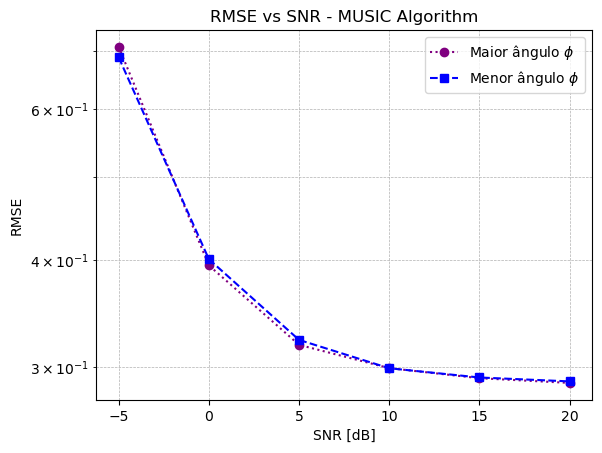

In [7]:
plt.figure()
plt.plot(snr_values, rmse_maior,marker='o', label='Maior ângulo $\phi$', linestyle = ':', color = 'purple')
plt.plot(snr_values, rmse_menor,marker='s', label='Menor ângulo $\phi$', linestyle = '--', color = 'blue')

plt.yscale("log")

plt.xlabel('SNR [dB]')
plt.ylabel('RMSE')
plt.title('RMSE vs SNR - MUSIC Algorithm')
plt.legend()
plt.xticks(snr_values)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.savefig('rmse_music.pdf')
plt.show()

# Root MUSIC Algorithm

Ângulos Verdadeiros: [-4 30]
Ângulos Estimados: [-4.33568946 30.29958146]


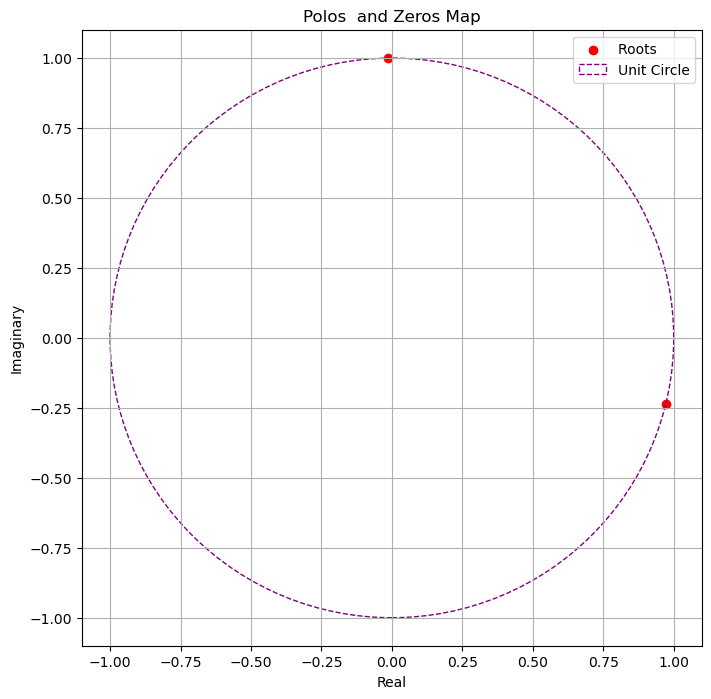

In [8]:
snr_db = 0  # SNR em dB
true_angles = np.array([-4, 30])

print(f"Ângulos Verdadeiros: {true_angles}")

# Geração dos sinais recebidos
signal_awgn = generate_signalawgn(A_ula, m_antennas, d_arrival, t_snapshot, snr_db)

# Cálculo do Root-MUSIC
estimated_angles, selected_roots = root_music(signal_awgn, m_antennas, d_arrival, true_angles)
print(f"Ângulos Estimados: {estimated_angles}")

# Plotando o mapa de polos
plt.figure(figsize=(8,8))
plt.scatter(selected_roots.real, selected_roots.imag, color='red', label='Roots ')
circle = plt.Circle((0, 0), 1, fill=False, color='purple', linestyle='--', label='Unit Circle')
plt.gca().add_patch(circle)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Polos  and Zeros Map')
plt.legend()
plt.grid()
plt.savefig('poles_map.pdf')
plt.show()

In [10]:
snr_values = np.arange(-5, 21, 5) # Valores de SNR em dB
iterations = 5000 # Número de iterações
t_snapshot = 100 # Número de snapshots
rmse_maior_root, rmse_menor_root = find_rmse_rootmusic(snr_values, iterations, m_antennas, d_arrival, t_snapshot)

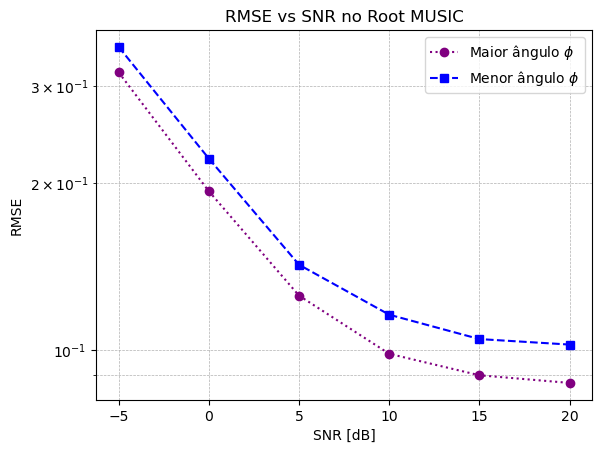

In [11]:
plt.figure()
plt.plot(snr_values, rmse_maior_root,marker='o', label='Maior ângulo $\phi$', linestyle = ':', color = 'purple')
plt.plot(snr_values, rmse_menor_root,marker='s', label='Menor ângulo $\phi$', linestyle = '--', color = 'blue')

plt.yscale("log")


plt.xlabel('SNR [dB]')
plt.ylabel('RMSE')
plt.title('RMSE vs SNR no Root MUSIC')
plt.legend()
plt.xticks(snr_values)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.savefig('rmse_rootmusic.pdf')
plt.show()

# Minimum Variance Distortionless Response (MVDR) Beamforming

In [12]:
# Parâmetros do sistema
m_antennas = 8  # Número de antenas
d_arrival = 2   # Número de fontes
t_snapshot = 100  # Snapshots
snr = 50  # SNR em dB
theta_target = 12  # Ângulo de interesse (graus)

# Gerar matriz A_ula com ângulos aleatórios
phit_uniform = [-30, 40]
A_ula = gerate_a_ula(m_antennas, d_arrival, phit_uniform)

# Aplicar o beamforming MVDR
B, theta_scan = mvdr_beamforming(A_ula, m_antennas, d_arrival, t_snapshot, snr, theta_target)

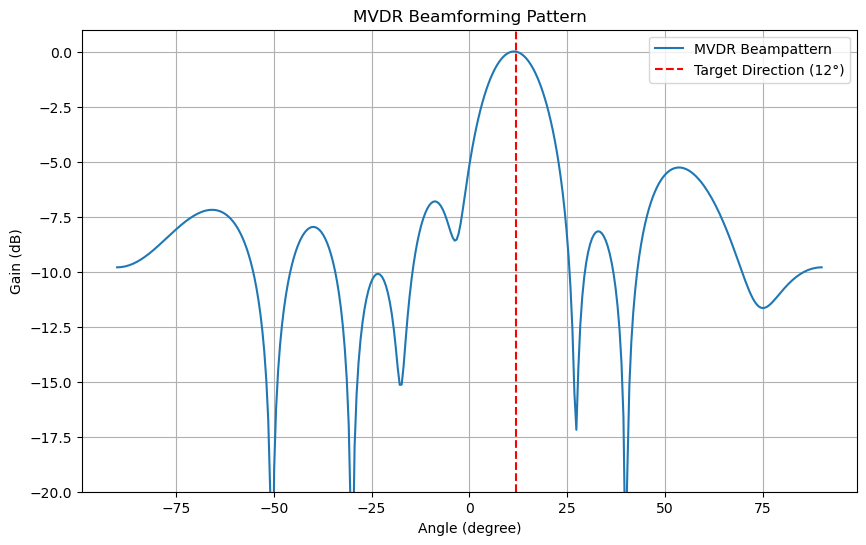

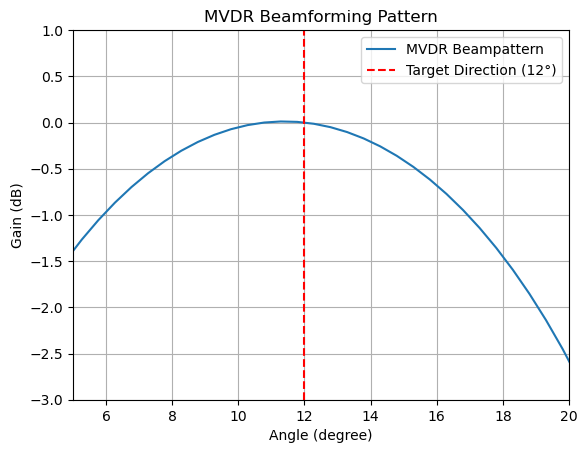

In [13]:

# Plotando o padrão de radiação
plt.figure(figsize=(10, 6))
plt.plot(theta_scan, B, label="MVDR Beampattern")
plt.axvline(theta_target, color="r", linestyle="--", label=f"Target Direction ({theta_target}°)")
plt.title("MVDR Beamforming Pattern")
plt.xlabel("Angle (degree)")
plt.ylabel("Gain (dB)")
plt.ylim([-20, 1])
plt.grid(True)
plt.legend()
plt.savefig('mvdr_beamforming.pdf')
plt.show()

# Plotando próximo ao pico
plt.figure()
plt.plot(theta_scan, B, label="MVDR Beampattern")
plt.axvline(theta_target, color="r", linestyle="--", label=f"Target Direction ({theta_target}°)")
plt.title("MVDR Beamforming Pattern")
plt.xlabel("Angle (degree)")
plt.ylabel("Gain (dB)")
plt.ylim([-3, 1])
plt.xlim([5, 20])
plt.grid(True)
plt.legend()
plt.savefig('mvdr_beamforming_zoom.pdf')
plt.show()